In [1]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [2]:
%matplotlib inline

from importlib import reload
import os
import numpy as np

import pandas

import h5py
import seaborn as sns
import pandas as pd
import umap

from ulmo import io as ulmo_io

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from tqdm import trange

In [3]:
### Load modis_2019 from s3
modis_data_file = "s3://modis-l2/PreProc/MODIS_R2019_2010_95clear_128x128_preproc_std.h5"
modis_data_2019 = ulmo_io.load_to_bytes(modis_data_file)

In [4]:
with h5py.File(modis_data_2019, 'r') as file:
    print(file.keys())
    modis_train_2019 = file['train'][:]

<KeysViewHDF5 ['train', 'train_metadata', 'valid', 'valid_metadata']>


In [5]:
modis_train_2019

(135712, 1, 64, 64)

In [ ]:
### Load train latents from s3
latents_last_file = 's3://modis-l2/modis_latents_simclr/MODIS_2010_train_last.h5'
latents_last = ulmo_io.load_to_bytes(latents_last_file)
#
with h5py.File(latents_last, 'r') as file:
    print(file.keys())
    latents_last = file['modis_latents'][:]

In [10]:
s3_reproduce_latents = 's3://modis-l2/modis_latents_last_batch_size_1.h5'
ulmo_io.download_file_from_s3(os.path.basename(s3_reproduce_latents), s3_reproduce_latents)

Done!


In [11]:
with h5py.File('modis_latents_last_reproduced.h5', 'r') as f:
    reproduced = f['modis_latents'][:]
reproduced.shape

(134162, 128)

In [14]:
### Initialize the linear transformer at first
scaler = StandardScaler()
### Estimate the parameters
scaler.fit(reproduced)
### Transform the latents
latents_std = scaler.transform(reproduced)

In [15]:
### Let's use PCA at first to estimate the dimension of the main components. But before that, we want to standarize the latent vector
pca = PCA(n_components='mle', random_state=0)
pca.fit(latents_std)
singular_vals = pca.singular_values_

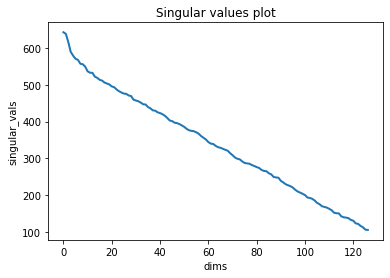

In [16]:
### plot the singular values to estimate the dimensions
plt.figure()
plt.title('Singular values plot')
plt.plot(singular_vals.squeeze(), linewidth=2)
plt.xlabel('dims')
plt.ylabel('singular_vals')
plt.show()

In [21]:
%%time
reducer_umap = umap.UMAP()
latents_mapping = reducer_umap.fit(latents_std)

CPU times: user 46min 44s, sys: 10min 27s, total: 57min 12s
Wall time: 9min 41s


In [22]:
import umap.plot

<AxesSubplot:>

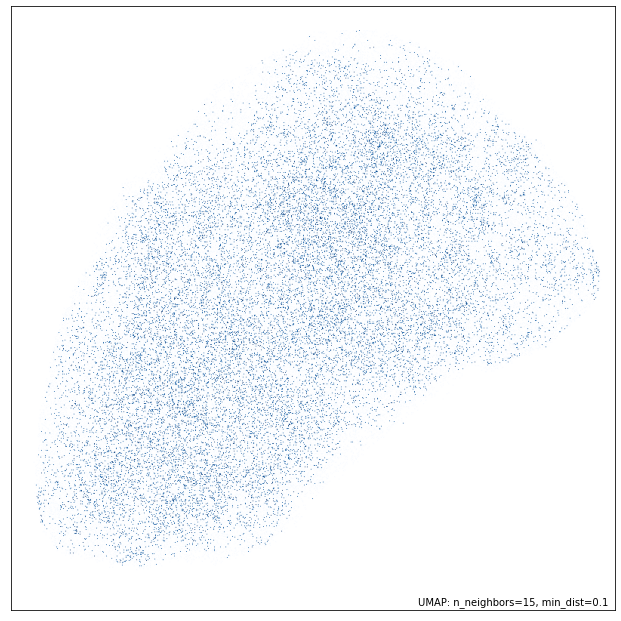

In [23]:
umap.plot.points(latents_mapping)